# Introduction
This notebook aims to show how to extract energy profile scans from a trained model. We show this for a local and EFA model on the SN2 dataset as well as for a local and an EFA augmented model for the cumulene structure.

In [34]:
import numpy as np
import jax
import jax.numpy as jnp
import jraph
import optax
import numpy as np
import e3x
import pathlib
import wandb
import sys

from euclidean_fast_attention import EnergyModel
from euclidean_fast_attention import NpzTrainer
from euclidean_fast_attention.utils import jraph_utils

import orbax.checkpoint as ocp
import pathlib


def load_params(ckpt_dir):
    loaded_mngr = ocp.CheckpointManager(
        pathlib.Path(ckpt_dir).expanduser().absolute().resolve(),
        item_names=('params', ),
        item_handlers={'params': ocp.StandardCheckpointHandler()},
        options=ocp.CheckpointManagerOptions(step_prefix="ckpt"),
    )
    restored = loaded_mngr.restore(
        loaded_mngr.latest_step(),
        args=None
    )

    return restored['params']

## SN2

In [31]:
def evaluate_on(data_path, ckpt_dir, model):
    atom_pair = pathlib.Path(data_path).stem
    print(f'Evaluate on atom pair {atom_pair}.')

    npztrainer_test = NpzTrainer(
    data_dir=data_path,
    num_train=0,
    num_valid=0,
    num_epochs=2000,
    max_num_nodes=7,
    max_num_edges=37,
    max_num_graphs=2,
    energy_unit=1,
    length_unit=1,
    save_interval_steps=2000,
    )

    params = load_params(ckpt_dir)
    
    @jax.jit
    def forward_fn(inputs):
        return model.apply(params, **inputs, calculate_forces=False)
    
    test_ds = npztrainer_test.prepare_testing_data(
        cutoff=model.cutoff, shuffle=False, subtract_energy_mean=False
    )
    energy_true = []
    energy_predict = []
    forces_predict = []
    
    for n, graph in enumerate(
        jraph.dynamically_batch(test_ds, n_node=7, n_edge=37, n_graph=2)
    ):
      graph = jax.tree.map(lambda x: jnp.array(x), graph)
      batch_info = jraph_utils.batch_segments_fn(graph)
      inputs = jraph_utils.jraph_to_input(graph)
      inputs.update({
          'batch_segments': batch_info['batch_segments'],
          'graph_mask': batch_info['graph_mask'],
      })
      
      energy_shift = jax.ops.segment_sum(
          np.take(shifts, graph.nodes['atomic_numbers']),
          segment_ids=inputs['batch_segments']
      )
      
      energy_true += [inputs['energy'][batch_info['graph_mask']]]
      inputs = {k: v for k, v in inputs.items() if (k not in ('energy', 'forces'))}
      energies = forward_fn(inputs) + energy_shift
      energy_predict += [energies[batch_info['graph_mask']]]
      
    energy_true = jnp.concatenate(energy_true, axis=0).reshape(-1)
    
    energy_predict = jnp.concatenate(energy_predict, axis=0).reshape(-1)
    
    return energy_predict, energy_true, atom_pair.split('_')


# During data pre-processing, per-atom specific shifts are subtracted, since simply taking the mean
# still can result in energy distributions with very large variance. By introducing atom dependend shifts
# this problem can be alleviated as e.g. described in https://www.nature.com/articles/s41467-023-36329-y
shifts = np.array([ 0.        , -3.5921101 ,  0.        ,  0.        ,  0.        ,
        0.        , -1.71485694,  0.        ,  0.        , -0.97762923,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.23682422,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.08449515,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.17498543])

In [32]:
atom_pair = 'F_I'

ckpt_dir_nl = f'../pretrained/sn2/sn2_with_efa_rcut5_01'
model_nl = EnergyModel(
    cutoff=5.,
    num_features=128,
    num_iterations=2,
    era_use_in_iterations=[0, 1],
    era_lebedev_num=50,
    era_include_pseudotensors=False,
    era_max_degree=0,
    era_qk_num_features=16,
    era_v_num_features=32,
    era_max_frequency=jnp.pi,
    era_max_length=20,
    era_activation_fn=e3x.nn.gelu,
)

ckpt_dir_l = f'../pretrained/sn2/sn2_without_efa_rcut10_01/'
model_l = EnergyModel(
    cutoff=10.,
    num_features=162,
    num_iterations=2,
)

e_pred_efa, e_true_efa, _ = evaluate_on(
    f'../datasets/sn2_{atom_pair}.npz',
    ckpt_dir=ckpt_dir_nl,
    model=model_nl
)

e_pred_loc, e_true_loc, _ = evaluate_on(
    f'../datasets/sn2_{atom_pair}.npz',
    ckpt_dir=ckpt_dir_l,
    model=model_l
)

Evaluate on atom pair sn2_F_I.


/Users/thorbenfrank/Documents/venvs/euclidean_fast_attention/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thorbenfrank/Documents/venvs/euclidean_fast_attention/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Evaluate on atom pair sn2_F_I.


/Users/thorbenfrank/Documents/venvs/euclidean_fast_attention/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thorbenfrank/Documents/venvs/euclidean_fast_attention/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


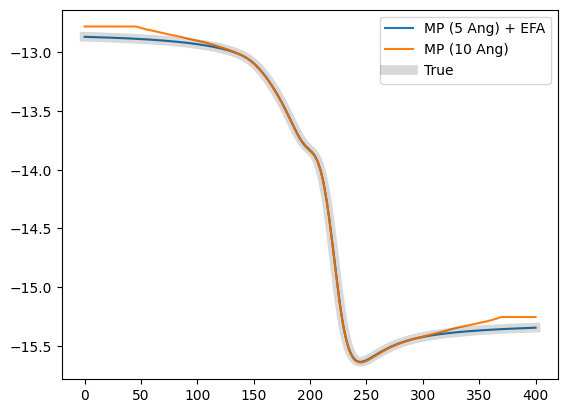

In [33]:
import matplotlib.pyplot as plt

plt.plot(e_pred_efa, label='MP (5 Ang) + EFA')
plt.plot(e_pred_loc, label='MP (10 Ang)')
plt.plot(e_true_efa, lw=7, c='k', alpha=0.15, label='True')
plt.legend()

## Cumulene

In [49]:
data_path = pathlib.Path(f'../datasets/cumulene_profile.npz').expanduser().resolve()

npztrainer_test = NpzTrainer(
    data_dir=data_path,
    num_train=0,
    num_valid=0,
    num_epochs=2000,
    max_num_nodes=70,
    max_num_edges=300,
    max_num_graphs=6,
    energy_unit=1,
    length_unit=1,
    save_interval_steps=2000,
)

model_nl = EnergyModel(
    cutoff=4.,
    mp_max_degree=2,
    num_features=64,
    num_iterations=3,
    era_use_in_iterations=[0, 1, 2],
    era_lebedev_num=50,
    era_include_pseudotensors=False,
    era_max_degree=0,
    era_qk_num_features=32,
    era_v_num_features=16,
    era_max_frequency=jnp.pi,
    era_max_length=15,
    atomic_dipole_embedding=False,
    era_activation_fn=e3x.nn.gelu,
    era_tensor_integration=False,
)

model_l = EnergyModel(
        cutoff=4.,
        mp_max_degree=2,
        num_features=84,
        num_iterations=3,
        era_use_in_iterations=None
)

ckpt_dir_nl = f'../pretrained/cumulene/cumulene_with_efa_num_iterations=3_efa_max_degree=1_seed=0/'
ckpt_dir_l = f'../pretrained/cumulene/cumulene_without_efa_num_iterations=3_seed=0/'

params_nl = load_params(ckpt_dir_nl)
params_l = load_params(ckpt_dir_l)

In [50]:
import jraph


mrot = e3x.so3.random_rotation(jax.random.PRNGKey(1234), num=10_000)

@jax.jit
def forward_fn_nl(inputs):
  return model_nl.apply(params_nl, **inputs, calculate_forces=False)

@jax.jit
def forward_fn_l(inputs):
  return model_l.apply(params_l, **inputs, calculate_forces=False)

test_ds = npztrainer_test.prepare_testing_data(
    cutoff=model_nl.cutoff, shuffle=False, subtract_energy_mean=False
)
energy_true = []
energy_predict_nl = []
energy_predict_nl_rot = []
energy_predict_l = []
for n, graph in enumerate(
    jraph.dynamically_batch(test_ds, n_node=2*13+1, n_edge=2*13*6+1, n_graph=3)
):
    graph = jax.tree.map(lambda x: jnp.array(x), graph)
    batch_info = jraph_utils.batch_segments_fn(graph)
    inputs = jraph_utils.jraph_to_input(graph)
    inputs.update(
        {
            'batch_segments': batch_info['batch_segments'],
            'graph_mask': batch_info['graph_mask'],
        }
    )
    
    energy_true += [inputs['energy'][batch_info['graph_mask']]]
    inputs = {k: v for k, v in inputs.items() if (k not in ('energy', 'forces'))}
    energies_nl = forward_fn_nl(inputs)
    
    inputs_rot = inputs.copy()
    inputs_rot['positions'] = jnp.einsum('ij, nj -> ni', mrot[n], inputs['positions'])
    energies_nl_rot = forward_fn_nl(inputs_rot)
    energies_l = forward_fn_l(inputs)
    
    energy_predict_nl += [energies_nl[batch_info['graph_mask']]]
    energy_predict_nl_rot += [energies_nl_rot[batch_info['graph_mask']]]
    energy_predict_l += [energies_l[batch_info['graph_mask']]]


energy_true = jnp.concatenate(energy_true, axis=0).reshape(-1)
energy_predict_l = jnp.concatenate(energy_predict_l, axis=0).reshape(-1)
energy_predict_nl = jnp.concatenate(energy_predict_nl, axis=0).reshape(-1)
energy_predict_nl_rot = jnp.concatenate(energy_predict_nl_rot, axis=0).reshape(-1)

/Users/thorbenfrank/Documents/venvs/euclidean_fast_attention/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thorbenfrank/Documents/venvs/euclidean_fast_attention/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


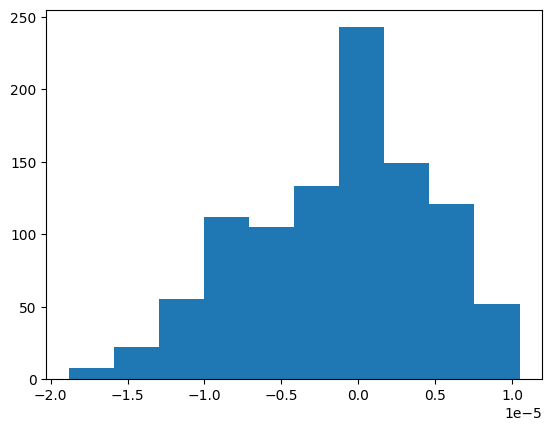

In [51]:
import matplotlib.pyplot as plt

# Lets check that the preditions of the EFA augmented model are acutally rotationally invariant
plt.hist(energy_predict_nl_rot - energy_predict_nl);

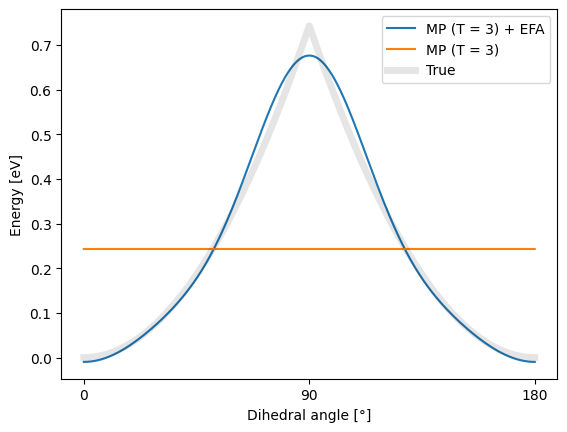

In [53]:
import matplotlib.pyplot as plt
from pathlib import Path

training_data_mean = 64.3609

plt.plot(
    np.linspace(0, 180, 2000), 
    np.concatenate([energy_predict_nl, energy_predict_nl[::-1]]) - training_data_mean - energy_true.min(),
    label='MP (T = 3) + EFA'
)

plt.plot(
    np.linspace(0, 180, 2000), 
    np.concatenate([energy_predict_l, energy_predict_l[::-1]]) - training_data_mean - energy_true.min(),
    label='MP (T = 3)'
)

plt.plot(
    np.linspace(0, 180, 2000), 
    np.concatenate([energy_true, energy_true[::-1]]) - energy_true.min(), 
    lw=5, 
    c='k', 
    alpha=0.1,
    label='True'
)

plt.xticks([0, 90, 180])
plt.xlabel('Dihedral angle [°]')
plt.ylabel('Energy [eV]')
plt.legend();